<a href="https://colab.research.google.com/github/ppokranguser/Artificial_Intelligence_study/blob/main/24_AI_CNN_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.5.1+cu121


### Let's load the CIFAR-100 dataset


In [ ]:
# Set the path to the CIFAR-100 dataset directory
data_path = './cifar100'

batch_size = 256

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),  # Randomly erase a portion of the image    # Convert the image to PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load the CIFAR-100 training dataset and apply transformation to convert images to tensors
train_dataset = torchvision.datasets.CIFAR100(data_path, train=True, transform=transform_train, download=True)
# Load the CIFAR-100 testing dataset and apply the same transformation
test_dataset = torchvision.datasets.CIFAR100(data_path, train=False, transform=transform_test, download=True)

# Create a DataLoader for the training and dataset with batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create a DataLoader for the testing dataset with batching (but no shuffling)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]


Extracting ./cifar100/cifar-100-python.tar.gz to ./cifar100
Files already downloaded and verified


### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Try to sample out one data point from dataloader

In [ ]:
# Get a single batch of data from the training dataloader
sample = next(iter(train_dataloader))

# Print the shape of the input images in the sample batch
print(sample[0].shape)
# Print the corresponding labels for the input images in the sample batch
print(sample[1])

torch.Size([256, 3, 32, 32])
tensor([ 2, 37, 94, 47, 35, 61, 19, 17, 12, 62, 98, 16, 58, 81, 77, 50, 14, 46,
        95, 68, 20, 10, 62, 88, 75, 34,  7, 85, 98, 98,  2, 95, 20, 39, 41, 26,
        65, 85, 66, 82, 20, 59, 68, 82, 39, 19, 37, 50,  7, 37, 51, 93, 74, 39,
        23, 99, 31, 13, 60,  2, 45, 19, 74,  2, 44, 61, 55, 53, 27, 66, 79, 49,
        98, 91, 20, 43, 88, 79, 83, 85, 16, 93, 53, 61, 57, 87, 14, 11, 70, 67,
        85,  3, 18, 96, 28, 30, 92, 17,  5, 51, 80, 52, 75, 32, 59, 34, 44, 15,
        50, 12,  2, 97, 72, 17, 92, 61, 60, 23, 69, 74, 83, 10, 77, 28, 59, 93,
        85, 81, 64, 35, 20, 70, 38, 95, 67, 17, 36, 56, 84, 44, 23, 63, 30, 72,
        70,  2, 32, 25, 98, 38,  6, 73,  5,  3, 67,  5,  4, 66, 95, 27, 77, 41,
         9, 10, 50, 99, 61, 82, 27, 50, 20, 95, 96, 60, 21, 51, 10, 87, 13, 39,
        83, 39, 92, 41, 64, 69, 80, 24, 74, 10, 78, 74, 34, 16,  0, 44, 75, 37,
        55, 84, 56, 23, 79, 92, 40, 48, 28, 21, 49, 14,  7, 94, 10, 93, 26, 62,
        69,

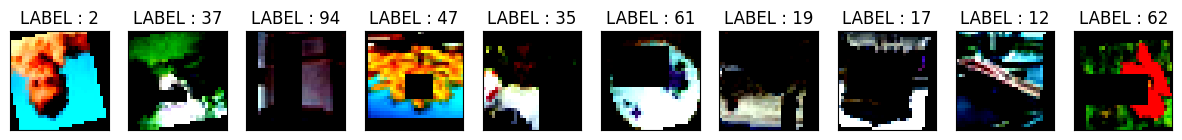

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))

# Loop over the first 10 samples in the batch
for plot_idx in range(10):
    # Display the image for the current sample
    # permute(1, 2, 0) changes the order of dimensions from (C, H, W) to (H, W, C)
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))

    # Set the title of the plot with the corresponding label
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))

    # Remove x and y ticks
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])

# Show the plot
plt.show()

### Define the Convolutional Neural Networks

---



In [ ]:


# 3x3 Convolution 정의
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# BasicBlock 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet 모델 정의
class MyModel(nn.Module):
    def __init__(self, img_size=32, num_class=100):
        super(MyModel, self).__init__()

        self.img_size = img_size
        self.num_class = num_class
        # Initialize in_channels here
        self.in_channels = 64

        # Define the layers of ResNet manually based on ResNet architecture principles
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, 64, 3)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out


### Define the Model

In [ ]:
model = MyModel()
model = model.to(device)

# Define the optimizer for updating the model parameters using the Adam optimizer
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr=1e-2, weight_decay=1e-5)

# Print the model architecture
print(model)

MyModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    # Set the model to training mode
    model.train()

    # Define the loss function and reset the gradients
    criterion = nn.CrossEntropyLoss()
    optimizer.zero_grad()

    # Get the input image and label from the sample
    img = sample[0].float().to(device)
    label = sample[1].long().to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    # Compute the number of correct predictions
    pred = model(img)
    num_correct = sum(torch.argmax(pred, dim=-1) == label)

    # Calculate the loss, Compute gradients, and Update weights
    pred_loss = criterion(pred, label)
    pred_loss.backward()
    optimizer.step()

    # Return the loss and the number of correct predictions
    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    # Set the model to evaluation mode
    model.eval()

    # Define the criterion for calculating the loss
    criterion = nn.CrossEntropyLoss()

    # Disable gradient computation for testing
    with torch.no_grad():
        # Extract the image and label from the sample
        img = sample[0].float().to(device)
        label = sample[1].long().to(device)

        # Perform forward pass to get predictions from the model
        # Calculate the loss based on the predictions and labels
        pred = model(img)
        pred_loss = criterion(pred, label)

        # Count the number of correctly predicted samples
        num_correct = sum(torch.argmax(pred, dim=-1) == label)

    # Return the loss and the number of correctly predicted samples
    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 100

# Lists to store training and testing losses
tr_loss_saver = []
te_loss_saver = []

# Iterate over each epoch
for epoch in tqdm(range(max_epoch)):
    ### Train Phase

    # Initialize Loss and Accuracy for training phase
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        # Call the train function to perform training on the current batch
        curr_loss, num_correct = train(model, optimizer, sample)

        # Update the total training loss and accuracy
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # Save the training loss
    tr_loss_saver.append(train_loss)

    # Save the model state after each epoch
    torch.save(model.state_dict(), 'recent.pth')

    ### Test Phase

    # Initialize Loss and Accuracy for testing phase
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        # Call the test function to evaluate the model on the current batch
        curr_loss, num_correct = test(model, sample)

        # Update the total testing loss and accuracy
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    # Save the testing loss
    te_loss_saver.append(test_loss)

    # Print the epoch-wise training and testing statistics
    print('[EPOCH {}] TR LOSS : {:.03f}, TE LOSS : {:.03f}, TR ACCU: {:.03f}, TE ACCU : {:.03f}'.format(epoch+1, train_loss, test_loss, train_accu, test_accu))


  0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 1] TR LOSS : 4.064, TE LOSS : 3.769, TR ACCU: 0.077, TE ACCU : 0.124
[EPOCH 2] TR LOSS : 3.522, TE LOSS : 3.427, TR ACCU: 0.155, TE ACCU : 0.174
[EPOCH 3] TR LOSS : 3.205, TE LOSS : 3.066, TR ACCU: 0.209, TE ACCU : 0.246
[EPOCH 4] TR LOSS : 2.947, TE LOSS : 3.166, TR ACCU: 0.258, TE ACCU : 0.242
[EPOCH 5] TR LOSS : 2.737, TE LOSS : 2.773, TR ACCU: 0.296, TE ACCU : 0.297
[EPOCH 6] TR LOSS : 2.556, TE LOSS : 2.724, TR ACCU: 0.334, TE ACCU : 0.331
[EPOCH 7] TR LOSS : 2.405, TE LOSS : 2.682, TR ACCU: 0.366, TE ACCU : 0.336
[EPOCH 8] TR LOSS : 2.271, TE LOSS : 2.309, TR ACCU: 0.395, TE ACCU : 0.391
[EPOCH 9] TR LOSS : 2.167, TE LOSS : 2.192, TR ACCU: 0.414, TE ACCU : 0.423
[EPOCH 10] TR LOSS : 2.055, TE LOSS : 2.052, TR ACCU: 0.441, TE ACCU : 0.441
[EPOCH 11] TR LOSS : 1.972, TE LOSS : 2.097, TR ACCU: 0.459, TE ACCU : 0.442
[EPOCH 12] TR LOSS : 1.902, TE LOSS : 1.990, TR ACCU: 0.477, TE ACCU : 0.466
[EPOCH 13] TR LOSS : 1.832, TE LOSS : 2.104, TR ACCU: 0.490, TE ACCU : 0.452
[EPOCH 1

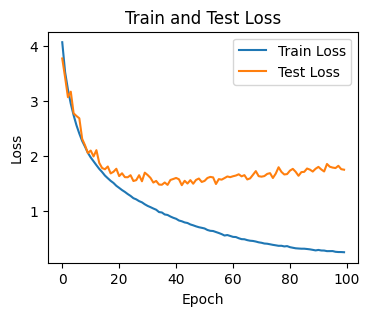

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(tr_loss_saver)  # Plot the training loss
plt.plot(te_loss_saver)  # Plot the testing loss
plt.legend(['Train Loss', 'Test Loss'])  # Add legend to the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Train and Test Loss')  # Title of the plot
plt.show()  # Display the plot